In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### Preprocess Data

In [7]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    table='uv_eg_10T', 
    freq=10,
    normalize_time=True
    )

### Kernel Composition - Locally Periodic

**Note**: Normalization of time range effects the period length hyperparams.
 - Solution? Normalize the range of period constraints

In [8]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.05, 0.15) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.15, 0.25) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

### Create, Train, and Perform Inference

Iter 1 , Loss = 0.8686162069036303 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.8496282538386366 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8027024031940102 , Noise = 0.5982704162597656
Iter 4 , Loss = 0.7727609297849596 , Noise = 0.5544614791870117
Iter 5 , Loss = 0.7442105020024011 , Noise = 0.5130730867385864
Iter 6 , Loss = 0.7071879941148626 , Noise = 0.47408729791641235
Iter 7 , Loss = 0.6707634149774533 , Noise = 0.437433660030365
Iter 8 , Loss = 0.6406719799103128 , Noise = 0.4030473530292511
Iter 9 , Loss = 0.6121105346804617 , Noise = 0.37088534235954285
Iter 10 , Loss = 0.5795351910675468 , Noise = 0.3408949375152588
Iter 11 , Loss = 0.5449103670438427 , Noise = 0.3129928410053253
Iter 12 , Loss = 0.5132437096045979 , Noise = 0.28708311915397644
Iter 13 , Loss = 0.4852047002129234 , Noise = 0.2630802094936371
Iter 14 , Loss = 0.4555209913186605 , Noise = 0.2409069687128067
Iter 15 , Loss = 0.42330288757833123 , Noise = 0.22047261893749237
Iter 16 , Loss = 0.39383034537

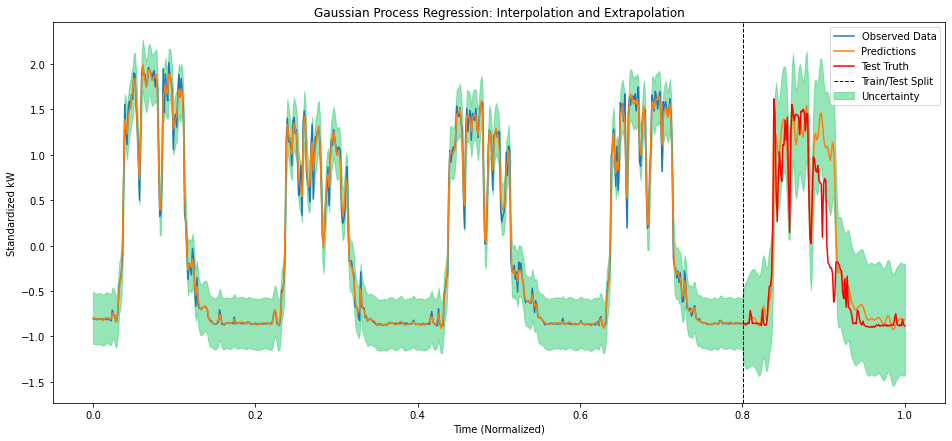

In [12]:
model, likelihood, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='10T',
    machine='ev_eg',
    update_score=True
)

In [13]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-4.3746])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.kernels.0.kernels.0.raw_outputscale',
              tensor(-2.6631)),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_lengthscale',
              tensor([[-3.7181]])),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_period_length',
              tensor([[0.8564]])),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_period_length_constraint.lower_bound',
              tensor(0.0500)),
   

In [14]:
mse, mape

(0.16070832516866432, 44.7905711181458)